In [21]:
!pip install 'h5py==2.10.0' --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-macosx_10_6_intel.whl (3.0 MB)
     |████████████████████████████████| 16.9 MB 5.8 MB/s eta 0:00:01
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
ERROR: torchvision 0.10.1 has requirement torch==1.9.1, but you'll have torch 1.9.0 which is incompatible.
ERROR: tensorflow-probability 0.12.2 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-compression 2.2 has requirement scipy~=1.5, but you'll have scipy 1.4.1 which is incompatible.
ERROR: tensorflow-compression 2.2 has requirement tensorflow~=2.5.0, but you'll have tensorflow 2.1.0 which is incompatible.
ERROR: lm-scorer 0.4.2 has requirement transformers<3.0.0,>=2.9.0, but you'll have transformers 4.9.0.dev0 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: six
    Found existing installation: six 

In [2]:
import pickle
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [3]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [5]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights


class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights



num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
top_k = 5000
target_vocab_size = top_k + 1
dropout_rate = 0.1

from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001, decay=1e-6)
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

# test = transformer.load_weights('image_caption_transformer_45.h5')


In [6]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  dec_mask = create_masks_decoder(output)
  result = [] #word list
  predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
  transformer.load_weights('image_caption_transformer_30.h5')
  for i in range(20):
      dec_mask = create_masks_decoder(output)
      # predictions.shape == (batch_size, seq_len, vocab_size)

      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

Predicted Caption: girl in pink bikini lying on her back in shallow pool of clear blue water


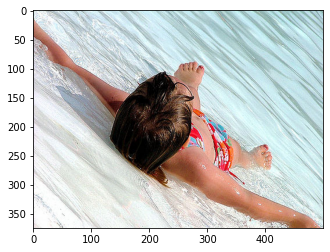

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_path = '../Flicker8k_Dataset/667626_18933d713e.jpg'
img, image_path = load_image(image_path)

caption,result,attention_weights = evaluate(image_path)


#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

        
#remove <end> from result         
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]


print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image_path))
plt.imshow(temp_image)